# Gesture Recognition

# Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

##Objectives:

1. Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

# Import required libraries

In [ ]:
import numpy as np
import os
import imageio # To imread and imresize
import datetime
from PIL import Image # To imread and imresize
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet


In [ ]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

# Upload the dataset in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path of the file
path_to_dataset = "/content/drive/MyDrive/Gesture_Recognition/Project_data.zip"
path = "/content/drive/MyDrive/Gesture_Recognition/Project_data"

In [ ]:
! ls /content/drive/MyDrive/Gesture_Recognition

Project_data.zip


In [ ]:
# Unzip the dataset from google drive in local environment in the folder dataset
import zipfile
zip_ref = zipfile.ZipFile(path_to_dataset, 'r')
zip_ref.extractall("/dataset")
zip_ref.close()

# Read the Folder Names for Training and Validation. 

**Note:** Set the batch size in such a way that we can use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [ ]:
folder_name ="/dataset/Project_data" 
train_doc = np.random.permutation(open(folder_name + '/train.csv').readlines())
val_doc = np.random.permutation(open(folder_name + '/val.csv').readlines())
batch_size = 64     #experiment with the batch size

# Plot the graphs for Training and validation, accuracy and loss function

In [ ]:
# Plot the graph for accuracy and loss of both training and validation dataset

def plot(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(num_epochs)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


# Create Callback directory function

In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

# Customized Generator Function

**Generator**

Generator is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with img_idx, y,z and normalization such that we get high accuracy.

In [ ]:
# Normalize the image by dividing the pixel values by 255 which resuilts the values range from 0 to 1
def normalise1(image):
  return image/255.

def generator(source_path, folder_list, batch_size,y,z,normalise):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                  
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.size[0] == 160:
                        image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) 
                    image = np.asarray(image).astype(np.float32)

                    
                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

# Read the sample image and understand the image properties. Do some experiments with sample image

In [ ]:
imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
image = imageio.imread(folder_name+'/train/'+ train_doc[0].strip().split(';')[0]+'/'+imgs[0]).astype(np.float32)
image

Array([[[ 90.,  66.,  49.],
        [ 92.,  65.,  49.],
        [ 97.,  66.,  49.],
        ...,
        [ 29.,  39.,  33.],
        [ 31.,  39.,  36.],
        [ 31.,  39.,  36.]],

       [[ 92.,  65.,  49.],
        [ 92.,  63.,  48.],
        [ 97.,  63.,  47.],
        ...,
        [ 56.,  67.,  61.],
        [ 39.,  47.,  44.],
        [ 32.,  40.,  37.]],

       [[ 92.,  58.,  44.],
        [ 92.,  58.,  44.],
        [ 97.,  60.,  48.],
        ...,
        [ 94., 103., 100.],
        [ 74.,  84.,  80.],
        [ 67.,  77.,  73.]],

       ...,

       [[ 60.,  45.,  41.],
        [ 69.,  54.,  50.],
        [190., 175., 173.],
        ...,
        [  1.,   7.,   3.],
        [  0.,   6.,   0.],
        [  0.,   6.,   0.]],

       [[ 30.,  28.,  13.],
        [ 87.,  85.,  70.],
        [199., 196., 184.],
        ...,
        [  2.,   5.,   1.],
        [  2.,   5.,   1.],
        [  1.,   4.,   0.]],

       [[ 33.,  39.,  17.],
        [128., 134., 111.],
        [185., 1

In [ ]:
imgs

['WIN_20180926_16_54_08_Pro_00010.png',
 'WIN_20180926_16_54_08_Pro_00008.png',
 'WIN_20180926_16_54_08_Pro_00054.png',
 'WIN_20180926_16_54_08_Pro_00044.png',
 'WIN_20180926_16_54_08_Pro_00056.png',
 'WIN_20180926_16_54_08_Pro_00040.png',
 'WIN_20180926_16_54_08_Pro_00064.png',
 'WIN_20180926_16_54_08_Pro_00036.png',
 'WIN_20180926_16_54_08_Pro_00060.png',
 'WIN_20180926_16_54_08_Pro_00034.png',
 'WIN_20180926_16_54_08_Pro_00030.png',
 'WIN_20180926_16_54_08_Pro_00050.png',
 'WIN_20180926_16_54_08_Pro_00016.png',
 'WIN_20180926_16_54_08_Pro_00022.png',
 'WIN_20180926_16_54_08_Pro_00062.png',
 'WIN_20180926_16_54_08_Pro_00038.png',
 'WIN_20180926_16_54_08_Pro_00024.png',
 'WIN_20180926_16_54_08_Pro_00014.png',
 'WIN_20180926_16_54_08_Pro_00012.png',
 'WIN_20180926_16_54_08_Pro_00018.png',
 'WIN_20180926_16_54_08_Pro_00046.png',
 'WIN_20180926_16_54_08_Pro_00026.png',
 'WIN_20180926_16_54_08_Pro_00028.png',
 'WIN_20180926_16_54_08_Pro_00058.png',
 'WIN_20180926_16_54_08_Pro_00020.png',


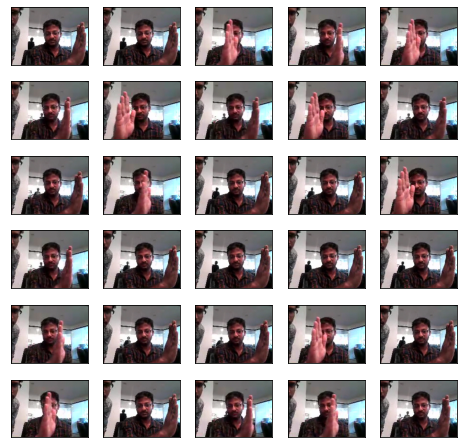

(120, 160, 3)
***********************After Resize*******************************************
(100, 100, 3)


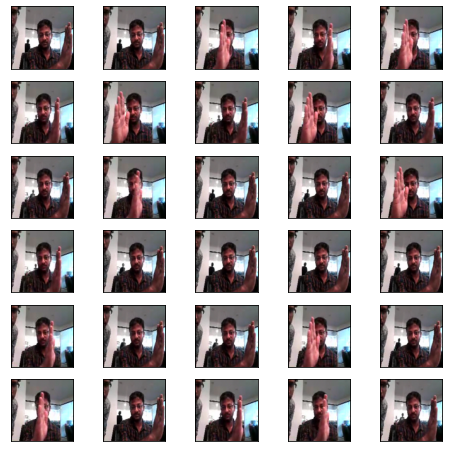

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image

imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
plt.figure(figsize=(8,8))
for item in range(len(imgs)): #  Iterate over the frames/images of a folder to read them in
  im = Image.open(folder_name+'/train/'+ train_doc[0].split(';')[0] +"/"+ imgs[item])
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)
 
plt.show()
print(im.shape)
print('***********************After Resize*******************************************')
plt.figure(figsize=(8,8))
for item in range (len(imgs)):
  im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[item])
  im = im.resize(size =(100,100))
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)

print(im.shape)
  

  

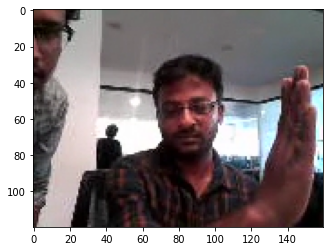

In [ ]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

In [ ]:
im.size

(160, 120)

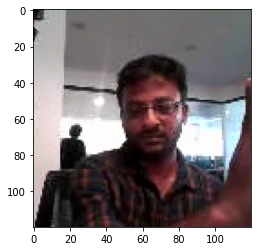

In [ ]:
# Crop the sample image
width, height =im.size
left = 20
top = 0
right = width - 20 
bottom = height
im = np.array(im.crop((left,top,right,bottom)))
plt.imshow(im)

In [ ]:
im.shape

(120, 120, 3)

**Note:** The dataset has 2 different size images (360 X 360 ) and (160 X 120)

In [ ]:
arr = np.array([[120,130,255],[250,255,0],[166,255,1]])
arr/255.

array([[0.47058824, 0.50980392, 1.        ],
       [0.98039216, 1.        , 0.        ],
       [0.65098039, 1.        , 0.00392157]])

## Model

Here we make the model using different functionalities that Keras provides. 
1. `Conv3D` and `MaxPooling3D` for a 3D convolution model. The last layer is the softmax.
2. `TimeDistributed` while building a Conv2D + RNN model.  The last layer is the softmax.

 **Note:** We have to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Conv3d Model architecture

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

# **Note:** The next step is to compile the model. When we print the summary of the model, we will see the total number of parameters we have to train.


**Note:**
Number of parameters depends on number of filters , filter size, number of layers, number of frames in a sequence, Image resolution, number of neurans in dense layers.

There are 30 frames in a sequence. To classify the video sequence we do not need all the frames.We can reduce the number of training parameters by reducing the number of frames in a sequence. So we will take the alternative frames of a sequence. [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] We are using 18 frames per video for training and validation.


In [ ]:
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)
y = 100
z = 100
conv3d_model = Conv3dArchitecture(x,y,z)
conv3d_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

In [ ]:
# Just to check the file name format
import datetime as dt
curr_dt_time = dt.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(curr_dt_time)
print(model_name)



2023-01-06 04:59:08.890151
model_init_2023-01-0604_59_08.890151/


In [ ]:
# Set the time to give unique filename to each checkpoint
import datetime 
curr_dt_time = datetime.datetime.now()
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Note:** Let us now fit the model. This will start training the model and with the help of the checkpoints, we will be able to save the model at the end of each epoch.

In [ ]:
# Count the sample dataset for each class
num =list(map(lambda x : x.replace('\n','')[-1], train_doc))
print(num.count('0'))
print(num.count('1'))
print(num.count('2'))
print(num.count('3'))
print(num.count('4'))

136
137
130
137
123


## Let us create a dummy model to check the Conv3d model architecture is working correcly or not, with small dataset and less epoch 

In [ ]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.

batch_size = 32
y = 100 # (y,z) is the Image resolution 
z = 100
normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc[0:160], batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc[0:40], batch_size,y,z,normalise)
num_epochs = 2

history = conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/2
14/14 [==============================] - ETA: 0s - loss: 3.0362 - categorical_accuracy: 0.3125Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-0506_30_15.800371/model-00001-3.03618-0.31250-1.59675-0.20000.h5
14/14 [==============================] - 40s 2s/step - loss: 3.0362 - categorical_accuracy: 0.3125 - val_loss: 1.5968 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
14/14 [==============================] - ETA: 0s - loss: 1.5653 - categorical_accuracy: 0.5067
Epoch 2: saving model to model_init_2023-01-0506_30_15.800371/model-00002-1.56534-0.50670-1.72842-0.30000.h5
14/14 [==============================] - 26s 2s/step - loss: 1.5653 - categorical_accuracy: 0.5067 - val_loss: 1.7284 - val_categorical_accuracy: 0.3000 - lr: 0.0010


In [ ]:
print(history.history['loss'])
print(history.history['categorical_accuracy'])
print(history.history['val_loss'])
print(history.history['val_categorical_accuracy'])

[0.5775214433670044, 0.561363160610199]
[0.7708333134651184, 0.7723214030265808]
[1.0512372255325317, 0.8589120507240295]
[0.5799999833106995, 0.699999988079071]


**Note:** 
1. The above dummy model shows that the accuracy for training data set is 56.13% for 2nd epoch and loss is decreasing. 
2. This shows that the model is trying to learn.
3. We can now create the model with whole dataset for training and validation. 


**Note:** 
1. For batch_size =64 , we are getting the Error:ResourceExhaustedError 
so we tried batch_size = 32 

# Model1 - Conv3D Architecture 
1. batch_size = 32
2. num_epochs = 20
3. Image resolution =(100 , 100)
4. Normalization method /255.

In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

### Set the values of number of epochs, batch_size,Image resolution and number of images in sequence 

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 50, 50, 128)  

In [ ]:

# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.9175 - categorical_accuracy: 0.3092Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-0506_30_15.800371/model-00001-2.91751-0.30920-1.62505-0.21000.h5
21/21 [==============================] - 47s 2s/step - loss: 2.9175 - categorical_accuracy: 0.3092 - val_loss: 1.6251 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.7473 - categorical_accuracy: 0.4163
Epoch 2: saving model to model_init_2023-01-0506_30_15.800371/model-00002-1.74728-0.41629-1.79476-0.20000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.7473 - categorical_accuracy: 0.4163 - val_loss: 1.7948 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

# Visualising the training result of Model1

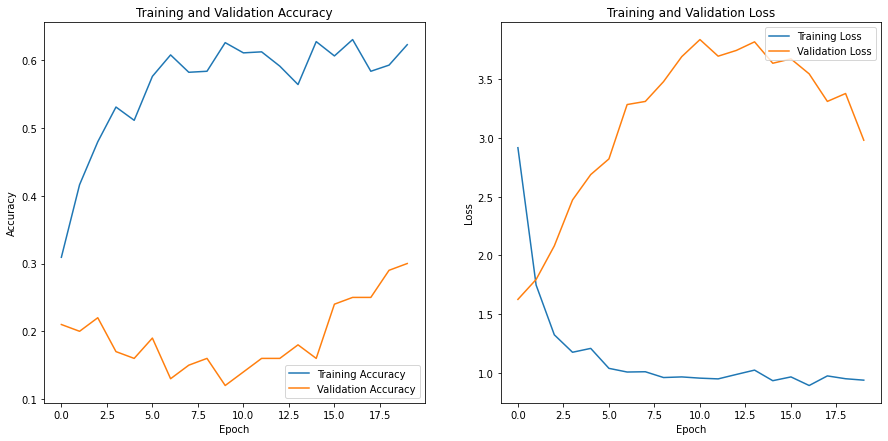

In [ ]:
# 
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
     

**Note:** 

1. Each epoch is taking 40-45 sec for training.
2. Till 15th epoch the validation accuracy is poor and validation loss is very high. After 15th epoch the validation accuracy started improving and validation loss started decreasing.



# Model2 - Conv3D Architecture 
1. batch_size = 32
2. num_epochs = 20
3. Image resolution =(80 , 80)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 80, 80, 64)    5248      
                                                                 
 batch_normalization_12 (Bat  (None, 18, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 80, 80, 64)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 40, 40, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 40, 40, 128)    221312    
                                                                 
 batch_normalization_13 (Bat  (None, 9, 40, 40, 128)  

In [ ]:
# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (80,80)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.9645 - categorical_accuracy: 0.3122Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (80,80)

Epoch 1: saving model to model_init_2023-01-0506_30_15.800371/model-00001-2.96455-0.31222-1.65553-0.22000.h5
21/21 [==============================] - 41s 2s/step - loss: 2.9645 - categorical_accuracy: 0.3122 - val_loss: 1.6555 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.8102 - categorical_accuracy: 0.4163
Epoch 2: saving model to model_init_2023-01-0506_30_15.800371/model-00002-1.81018-0.41629-1.98189-0.23000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.8102 - categorical_accuracy: 0.4163 - val_loss: 1.9819 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - 

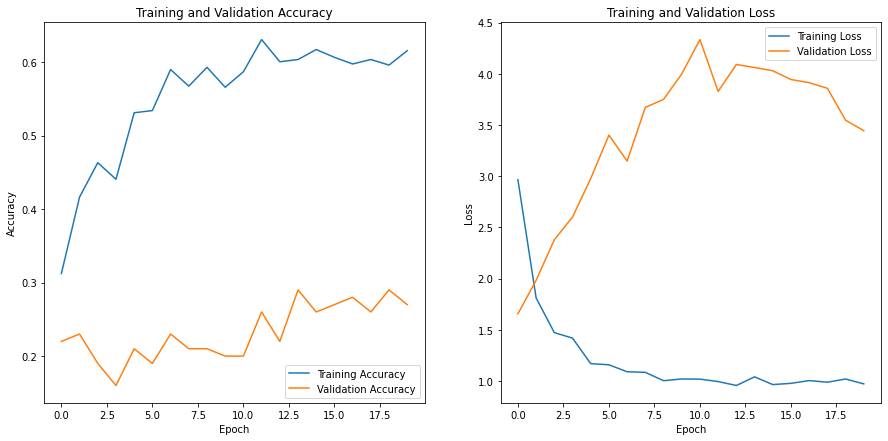

In [ ]:
# Visualizing the model accuracy and loss
# 
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**Note:** There is no improvement in the performance of the model after reducing the resolution of the image

**Decision:** Set the image resolution (120,120)

**Note:** 
1. We tried to create a Conv3D model by considering training image resolution (120,120)
2. We end up with the Error: ResourceExhaustedError  

**Decision:**
1. Change the batch size to 16 and keep Image Resolution (80,80) check the model performance.

# Model3 - Conv3D Architecture 
1. batch_size = 16
2. num_epochs = 20
3. Image resolution =(80,80)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 16

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 80, 80, 64)    5248      
                                                                 
 batch_normalization_20 (Bat  (None, 18, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 18, 80, 80, 64)    0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 40, 40, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 40, 40, 128)    221312    
                                                                 
 batch_normalization_21 (Bat  (None, 9, 40, 40, 128)  

In [ ]:
# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 16 ;Image resolution = (80,80)
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.5247 - categorical_accuracy: 0.3424Source path =  /dataset/Project_data/val ; batch size = 16 ;Image resolution = (80,80)

Epoch 1: saving model to model_init_2023-01-0506_30_15.800371/model-00001-2.52467-0.34238-nan-0.18000.h5
42/42 [==============================] - 38s 871ms/step - loss: 2.5247 - categorical_accuracy: 0.3424 - val_loss: nan - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2051
Epoch 2: saving model to model_init_2023-01-0506_30_15.800371/model-00002-nan-0.20513-nan-0.20000.h5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 [==============================] - 37s 889ms/step - loss: nan - categorical_accuracy: 0.2051 - val_loss: nan - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epo

**Note:** 
1. There is no improvement in the model performance 
2. The loss of both training and validation dataset becomes nan means loss diverge to infinity.

**Decision:**
Let us change the Conv3D architecture by removing a layer of conv3d unit 

# Take Model1 and run for more epochs

**Note:** Model1 is showing some improving training and validation accuracy and decreasing loss.   

**Decision:** We can increase the number of epochs for the model1 and check the result

# Model4 - Conv3D Architecture 
1. batch_size = 32
2. num_epochs = 30 # Increase the number of epochs 
3. Image resolution =(100 , 100)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 30 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

# Call the file path creating callback_dirctory function 
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 50, 50, 128)  

In [ ]:
# Let us create the train_generator and the val_generator which will be used in .fit.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.9842 - categorical_accuracy: 0.3002Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-0604_59_11.187500/model-00001-2.98417-0.30015-1.62976-0.23000.h5
21/21 [==============================] - 57s 2s/step - loss: 2.9842 - categorical_accuracy: 0.3002 - val_loss: 1.6298 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6911 - categorical_accuracy: 0.4404
Epoch 2: saving model to model_init_2023-01-0604_59_11.187500/model-00002-1.69111-0.44042-1.81949-0.22000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.6911 - categorical_accuracy: 0.4404 - val_loss: 1.8195 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0

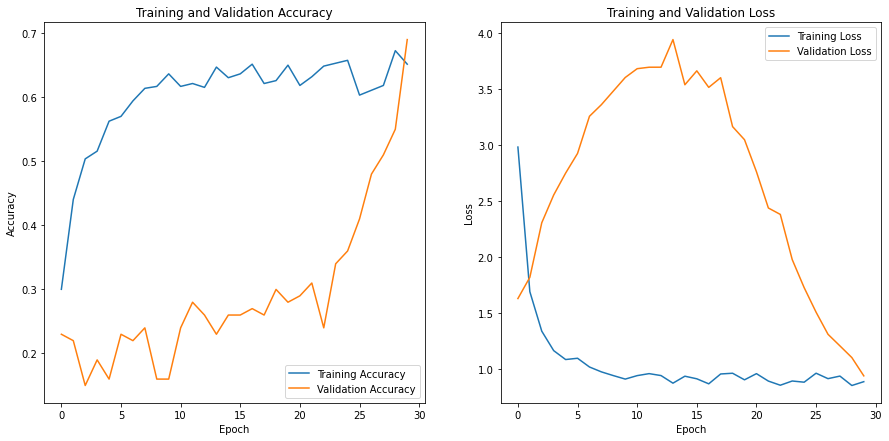

In [ ]:
# 
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**Note:** 
1. The above model shows that afetr 15th epoch the accuracy for validation dataset starts improving  and validation loss starts decreases.
2. This is a good sign we can get a good model with high validation accuracy and low validation loss if we train the model further.
 


# Conv3D Architecture 2
1. Reduce the training parameters

  a. By reducing the number of filters in each Conv3D layer

  b. By reducing the number of neurons in last dense layer 


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def conv3d_architecture1(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
  
  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(256, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

# CNN + RNN Stack Architecture

#### Here we make the model using different functionalities that Keras provides. We will use TimeDistributed, GRU and other RNN structures after doing transfer learning. Also the last layer is the softmax. 

**Note:** Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

# Model 5 - CNN-LSTM Model
1. Transfer learning using VGG16 imagenet
2. batch_size = 32
3. Number of Epochs = 30
4. Image Size = 100*100
5. Optimizer = SGD

In [1]:
def cnn_lstm(x,y,z):
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))

  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32))

  model.add(Dense(8, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model


In [ ]:

# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 30 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



In [ ]:
# Compile the conv3d_model
# Using sgd optimizer

sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model5 = cnn_lstm(x,y,z)
model5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 18, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                                 
Total params: 15,055,413
Trainable params: 340,725
Non-trainable params: 14,714,688
____________________________________

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6062 - categorical_accuracy: 0.1931Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-0914_03_10.269682/model-00001-1.60617-0.19306-1.59624-0.22000.h5
21/21 [==============================] - 45s 2s/step - loss: 1.6062 - categorical_accuracy: 0.1931 - val_loss: 1.5962 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5845 - categorical_accuracy: 0.2338
Epoch 2: saving model to model_init_2023-01-0914_03_10.269682/model-00002-1.58445-0.23379-1.57862-0.25000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.5845 - categorical_accuracy: 0.2338 - val_loss: 1.5786 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0

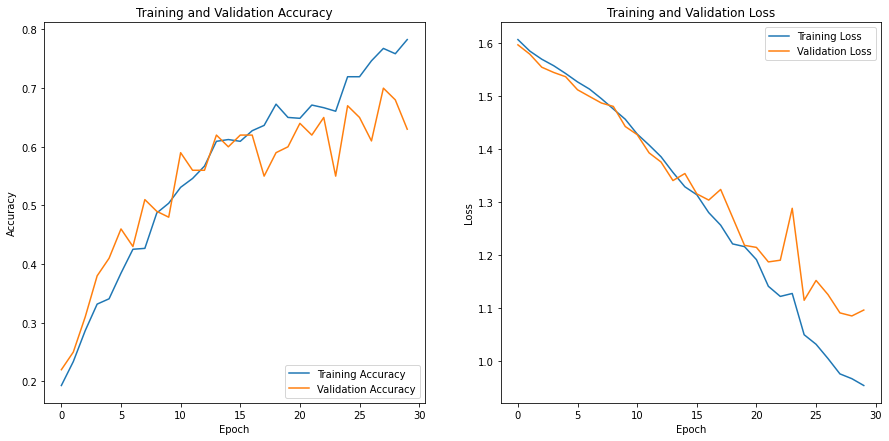

In [ ]:
plot(history_model5)

**Observation**
1. Training Accuracy: 78
2. Validation Accuracy: 63
3. Train Loss: 0.95
4. Val Loss: 1.09
5. We need to explore more models to increase accuracy.

# Model 6 - CNN GRU and Transfer Learning
1. Transfer learning using VGG16 imagenet
2. batch_size = 32
3. Number of Epochs = 20
4. Image Size = 100*100
5. Optimizer = Adam

In [ ]:
def cnn_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam()
model6 = cnn_gru(x,y,z,0.25)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 128)           74496     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5046 - categorical_accuracy: 0.3137Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-0918_58_22.542327/model-00001-1.50462-0.31373-1.24381-0.46000.h5
21/21 [==============================] - 49s 2s/step - loss: 1.5046 - categorical_accuracy: 0.3137 - val_loss: 1.2438 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0766 - categorical_accuracy: 0.5837
Epoch 2: saving model to model_init_2023-01-0918_58_22.542327/model-00002-1.07665-0.58371-0.99295-0.64000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.0766 - categorical_accuracy: 0.5837 - val_loss: 0.9930 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

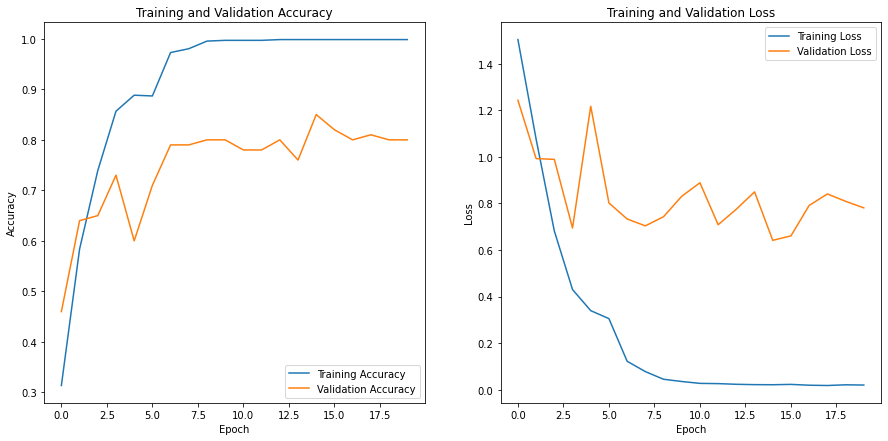

In [ ]:
plot(history_model6)

**Observation**
1. Training Accuracy: 99.8
2. Validation Accuracy: 85
3. Train Loss: 0.02
4. Val Loss: 0.64
5. This model is overfitting. So next we will apply some techniques to control overfitting.

# Model 6.2 CNN and GRU with transfer learning
Since the model is overfitting lets try learning rate for optimizer on the model 6


In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
model6_2 = cnn_gru(x,y,z, 0.25)
model6_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_10 (GRU)                (None, 18, 128)           74496     
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
#Fit the model
num_epochs=20
history_model6_2 = model6_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5931 - categorical_accuracy: 0.2655
Epoch 1: saving model to model_init_2023-01-0918_58_22.542327/model-00001-1.59311-0.26546-1.55407-0.43000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.5931 - categorical_accuracy: 0.2655 - val_loss: 1.5541 - val_categorical_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5266 - categorical_accuracy: 0.4238
Epoch 2: saving model to model_init_2023-01-0918_58_22.542327/model-00002-1.52664-0.42383-1.47346-0.50000.h5
21/21 [==============================] - 42s 2s/step - loss: 1.5266 - categorical_accuracy: 0.4238 - val_loss: 1.4735 - val_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4263 - categorical_accuracy: 0.4977
Epoch 3: saving model to model_init_2023-01-0918_58_22.542327/model-00003-1.42629-0.49774-1.36528-0.52000.h5
21/21 [========

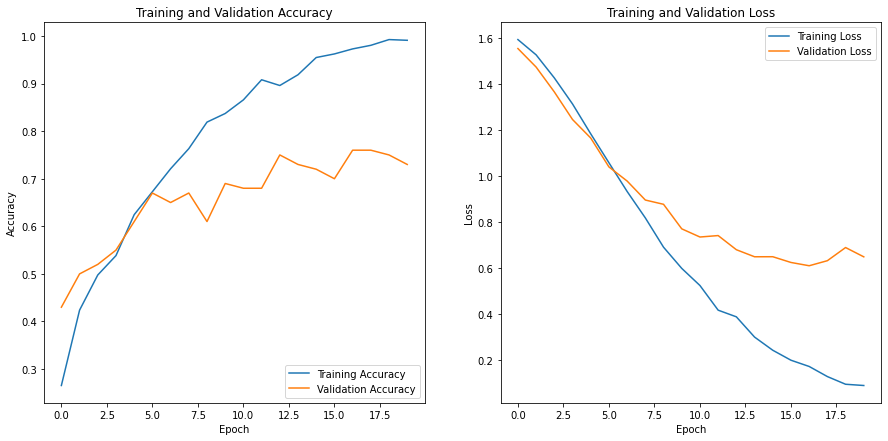

In [ ]:
plot(history_model6_2)


**Observation**
1. Training Accuracy: 98
2. Validation Accuracy: 76
3. Train Loss: 0.12
4. Val Loss: 0.63
5. The model is still overfitting

# Model 6_3
Lets try to increase dropout values on the same model.

In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
model6_3 = cnn_gru(x,y,z, 0.5)
model6_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 128)           74496     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                      

In [ ]:
#Fit the model
num_epochs=20
history_model6_3 = model6_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5984 - categorical_accuracy: 0.2564Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1009_53_18.058699/model-00001-1.59838-0.25641-1.56556-0.29000.h5
21/21 [==============================] - 72s 3s/step - loss: 1.5984 - categorical_accuracy: 0.2564 - val_loss: 1.5656 - val_categorical_accuracy: 0.2900 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5379 - categorical_accuracy: 0.3318
Epoch 2: saving model to model_init_2023-01-1009_53_18.058699/model-00002-1.53794-0.33183-1.48547-0.39000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.5379 - categorical_accuracy: 0.3318 - val_loss: 1.4855 - val_categorical_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] 

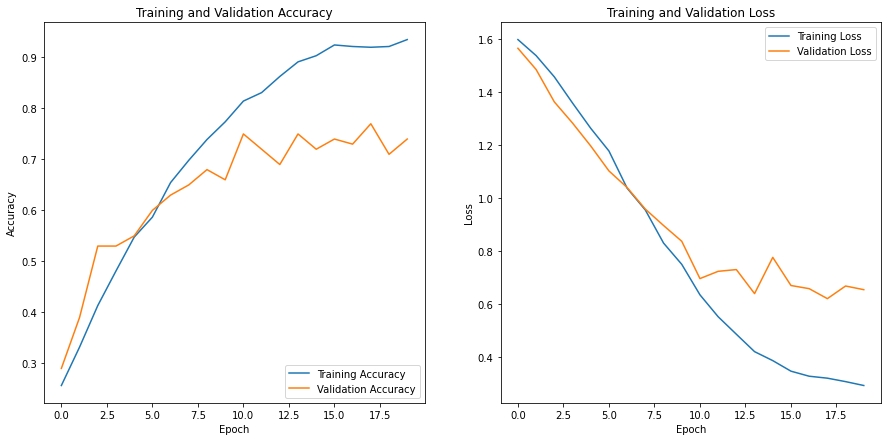

In [ ]:
plot(history_model6_3)


**Observation**
1. Training Accuracy: 92
2. Validation Accuracy: 77
3. Train Loss: 0.32
4. Val Loss: 0.62
5. The model is still overfitting.

# Model 6_4
Lets add more dropout layers to control overfitting.

In [ ]:
def cnn_gru_4(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 15 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model6_4 = cnn_gru_4(x,y,z,0.25)
model6_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_4.summary())

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 18, 128)           74496     
                                                                 
 dropout (Dropout)           (None, 18, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                41

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model6_4 = model6_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6172 - categorical_accuracy: 0.2217Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1106_51_30.902357/model-00001-1.61721-0.22172-1.57882-0.30000.h5
21/21 [==============================] - 71s 3s/step - loss: 1.6172 - categorical_accuracy: 0.2217 - val_loss: 1.5788 - val_categorical_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5738 - categorical_accuracy: 0.2670
Epoch 2: saving model to model_init_2023-01-1106_51_30.902357/model-00002-1.57376-0.26697-1.53784-0.21000.h5
21/21 [==============================] - 45s 2s/step - loss: 1.5738 - categorical_accuracy: 0.2670 - val_loss: 1.5378 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 3/15
21/21 [==============================] 

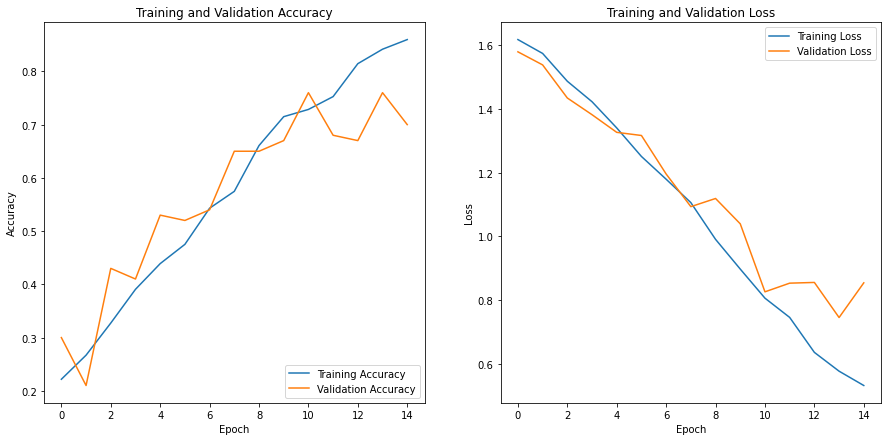

In [ ]:
plot(history_model6_4)


**Observation**
1. Training Accuracy: 84
2. Validation Accuracy: 76
3. Train Loss: 0.57
4. Val Loss: 0.74
5. The model is less overfitting now but We need to explore more models to increase accuracy.

# Model 7
CNN, LSTM and GRU with transfer learning

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(GRU(64, return_sequences=True))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam()
model7 = cnn_lstm_gru(x,y,z)
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 18, 128)           98816     
                                                                 
 gru_17 (GRU)                (None, 18, 64)            37248     
                                                                 
 gru_18 (GRU)                (None, 32)                9408      
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
num_epochs=20
history_model7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5468 - categorical_accuracy: 0.3107Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1010_57_29.787405/model-00001-1.54675-0.31071-1.39565-0.44000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.5468 - categorical_accuracy: 0.3107 - val_loss: 1.3956 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2550 - categorical_accuracy: 0.4736
Epoch 2: saving model to model_init_2023-01-1010_57_29.787405/model-00002-1.25497-0.47360-1.12572-0.56000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.2550 - categorical_accuracy: 0.4736 - val_loss: 1.1257 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

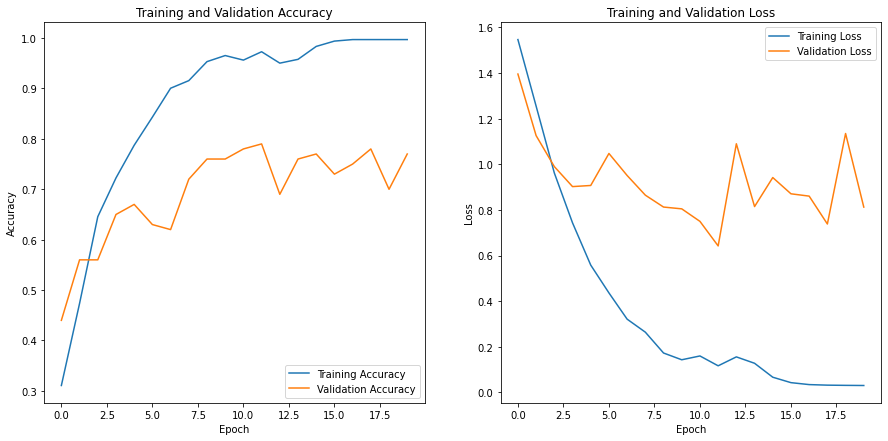

In [ ]:
plot(history_model7)


**Observation**
1. Training Accuracy: 97
2. Validation Accuracy: 79
3. Train Loss: 0.11
4. Val Loss: 0.64
5. The model is overfitting and we need to control overfitting by providing learning rate and drop out layers

# Model 7_2
Try adding learning rate and dropout layers

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model7_2 = cnn_lstm_gru(x,y,z,0.25)
model7_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7_2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 18, 128)           98816     
                                                                 
 gru_17 (GRU)                (None, 18, 64)            37248     
                                                                 
 gru_18 (GRU)                (None, 32)                9408      
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
num_epochs=15
history_model7_2 = model7_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.2142Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1011_30_28.579435/model-00001-1.61083-0.21418-1.59176-0.32000.h5
21/21 [==============================] - 46s 2s/step - loss: 1.6108 - categorical_accuracy: 0.2142 - val_loss: 1.5918 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5806 - categorical_accuracy: 0.2896
Epoch 2: saving model to model_init_2023-01-1011_30_28.579435/model-00002-1.58057-0.28959-1.54912-0.34000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.5806 - categorical_accuracy: 0.2896 - val_loss: 1.5491 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 3/15
21/21 [==============================] 

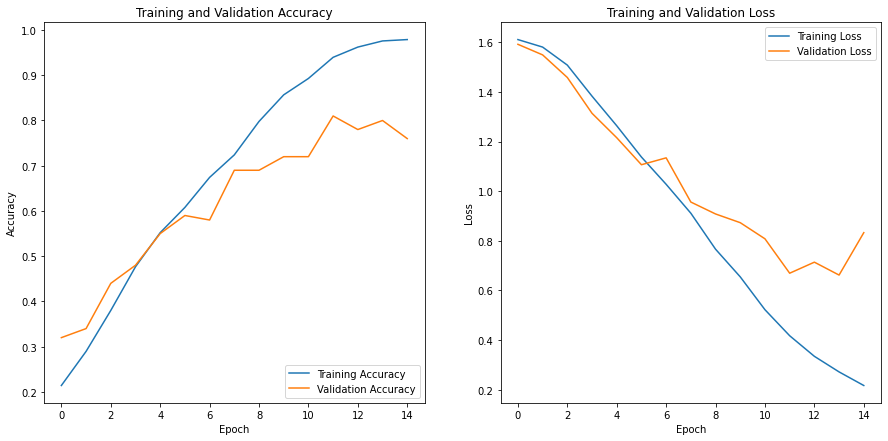

In [ ]:
plot(history_model7_2)


**Observation**
1. Training Accuracy: 93.9
2. Validation Accuracy: 81
3. Train Loss: 0.41
4. Val Loss: 0.66
5. Good model but we can still further try to decrease gap between training and validation accuracy

# Data Augmentation

# Using Augmentation techniques to improve the accuracy of the model

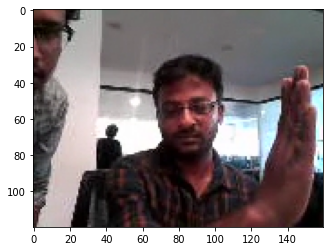

In [ ]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

In [ ]:
im.size

(160, 120)

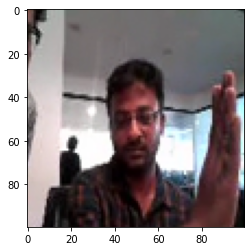

In [ ]:
shifted = im.transform(im.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
gray = shifted.convert('L')
image = np.asarray(gray).astype(np.float32)
x0, y0 = np.argwhere(image > 0).min(axis=0)
x1, y1 = np.argwhere(image > 0).max(axis=0) 

cropped = shifted.crop((y0,x0,y1,x1))
im_resized = cropped.resize(size=(100,100))
plt.imshow(im_resized)

In [ ]:
print(x0,y0,x1,y1)

10 0 119 146


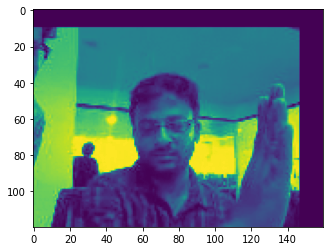

In [ ]:
plt.imshow(gray)

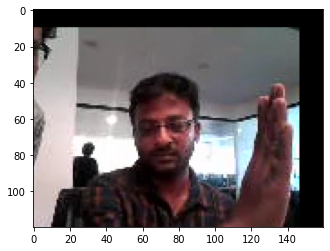

In [ ]:
plt.imshow(shifted)

In [ ]:
#Image Augmentation Function
def image_augment(image,y,z):
  shifted = image.transform(image.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
  gray = shifted.convert('L')
  im = np.asarray(gray).astype(np.float32)
  x0, y0 = np.argwhere(im > 0).min(axis=0)
  x1, y1 = np.argwhere(im > 0).max(axis=0) 

  cropped = shifted.crop((y0,x0,y1,x1))
  im_resized = np.asarray(cropped.resize(size=(y,z))).astype(np.float32)
  return(im_resized)

## Generator with Data Augmentation techniques

In [ ]:
def generator_with_aug(source_path, folder_list, batch_size,y,z,normalise,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            # Newly added code for data augmentation 
            if(augment == True):
              batch_data_aug = np.zeros((batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    # Newly added code for data augmentation(Translate the image randomly, crop and resize )
                    if( augment == True):
                      im_aug = image_augment(image,y,z)

                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                    
                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                    #Newly added code( Normalise the augmented image data)
                    if(augment == True):
                      batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                      batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                      batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                
            # Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
            if(augment == True):
              batch_data=np.concatenate([batch_data,batch_data_aug])
              batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
          batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
          batch_labels = np.zeros((len(t)%batch_size,5))
          if(augment == True):
             batch_data_aug = np.zeros((len(t)%batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data

          for folder in range(len(t)%batch_size):
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
              image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
              # Newly added code for data augmentation(Translate the image randomly, crop and resize )
              if(augment==True):
                im_aug = image_augment(image,y,z)

              if image.size[0] == 160:
                image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120
                                       
              image = image.resize(size = (y,z)) 
              image = np.asarray(image).astype(np.float32)

                    
              batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

              #Newly added code( Normalise the augmented image data)
              if(augment == True):
                batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])

            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

          #Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
          if(augment==True):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

          yield batch_data, batch_labels

# Model 8.1: Conv3D Archtecture with data augmentation
## Build the Conv3D model with data augmentation

1. batch_size =20
2. num_epochs = 20
3. Image Resolution=(100,100)

In [ ]:
def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 20

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
# The generator will creates batch_size * 2 data {(raw_data) + (augmented_data)} for one batch
# But number of steps per epoch is same but for each batch number of samples increased

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size) 
else:
    steps_per_epoch = (num_train_sequences//batch_size ) + 1 
# batch size of validation data should be   
if (num_val_sequences%(batch_size)) == 0:
    validation_steps = int(num_val_sequences/(batch_size))
else:
    validation_steps = (num_val_sequences//(batch_size)) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise,augment=True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Source path =  /dataset/Project_data/train ; batch size = 20 ;Image resolution = (100,100)
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.6876 - categorical_accuracy: 0.3160Source path =  /dataset/Project_data/val ; batch size = 20 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1019_44_07.222553/model-00001-2.68762-0.31599-1.78252-0.16000.h5
34/34 [==============================] - 98s 3s/step - loss: 2.6876 - categorical_accuracy: 0.3160 - val_loss: 1.7825 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5697 - categorical_accuracy: 0.3876
Epoch 2: saving model to model_init_2023-01-1019_44_07.222553/model-00002-1.56967-0.38763-2.01178-0.18000.h5
34/34 [==============================] - 77s 2s/step - loss: 1.5697 - categorical_accuracy: 0.3876 - val_loss: 2.0118 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0

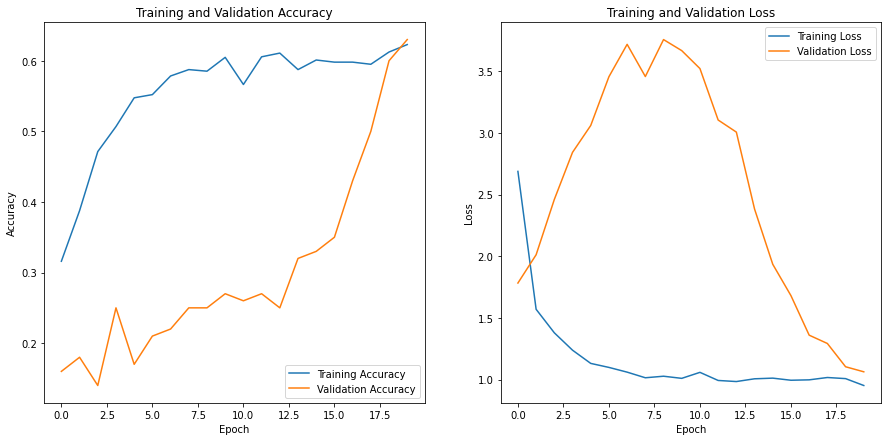

In [ ]:
plot(history_model1,20)

# Note: Good Model

**Decision:** 
1. Save the final epoch model for future use
2. We can run this model for some more epochs to get the good accuracy

# Model 9
Lets apply augmentation on our best model so far which is 7.2

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):
    
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)
    
  for layer in base_model.layers:
      layer.trainable = False
        
  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))
 
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model


In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model9 = cnn_lstm_gru(x,y,z,0.25)
model9.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 18, 128)           98816     
                                                                 
 dropout_3 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 18, 64)            37248     
                                                                 
 dropout_4 (Dropout)         (None, 18, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                      

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model

history_model9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.2119Source path =  /dataset/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1110_18_49.427501/model-00001-1.61048-0.21192-1.57117-0.33000.h5
21/21 [==============================] - 128s 5s/step - loss: 1.6105 - categorical_accuracy: 0.2119 - val_loss: 1.5712 - val_categorical_accuracy: 0.3300 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5526 - categorical_accuracy: 0.3213
Epoch 2: saving model to model_init_2023-01-1110_18_49.427501/model-00002-1.55260-0.32127-1.49005-0.40000.h5
21/21 [==============================] - 74s 4s/step - loss: 1.5526 - categorical_accuracy: 0.3213 - val_loss: 1.4901 - val_categorical_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================]

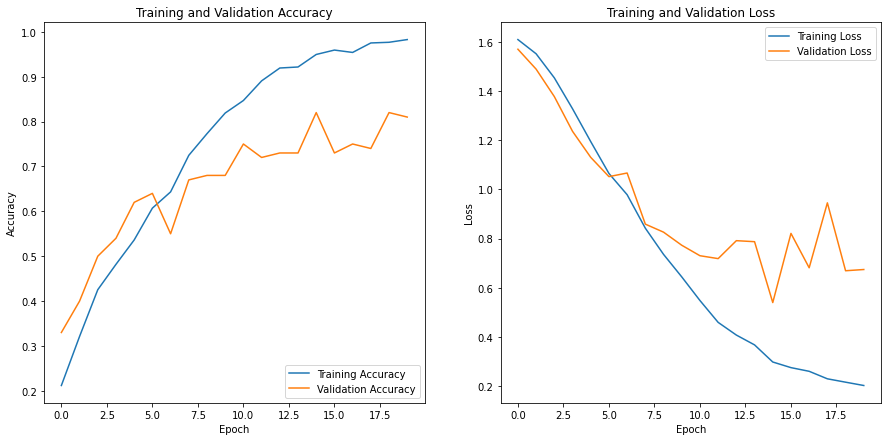

In [ ]:
plot(history_model9)


**Observation**
1. Training Accuracy: 97.6
2. Validation Accuracy: 82
3. Train Loss: 0.21
4. Val Loss: 0.66
5. This model is overfitting and we need to control the same.

# Model 10
Transfer Learrning using Mobilenet and GRU

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


In [ ]:
def cnn_gru(x,y,z,dropout):
  model = Sequential()
  model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))

  model.add(GRU(128))
  model.add(Dropout(dropout))
    
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(dropout))
    
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 16
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model10 = cnn_gru(x,y,z,0.25)
model10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
# Call the file path creating callback_dirctory function 
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dataset/Project_data/train ; batch size = 16 ;Image resolution = (100,100)
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.5805 - categorical_accuracy: 0.3213Source path =  /dataset/Project_data/val ; batch size = 16 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2023-01-1113_05_48.164011/model-00001-1.58052-0.32127-1.33351-0.45000.h5
42/42 [==============================] - 81s 2s/step - loss: 1.5805 - categorical_accuracy: 0.3213 - val_loss: 1.3335 - val_categorical_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.0673 - categorical_accuracy: 0.6003
Epoch 2: saving model to model_init_2023-01-1113_05_48.164011/model-00002-1.06732-0.60030-0.98792-0.63000.h5
42/42 [==============================] - 72s 2s/step - loss: 1.0673 - categorical_accuracy: 0.6003 - val_loss: 0.9879 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 3/20
42/42 [==============================] 

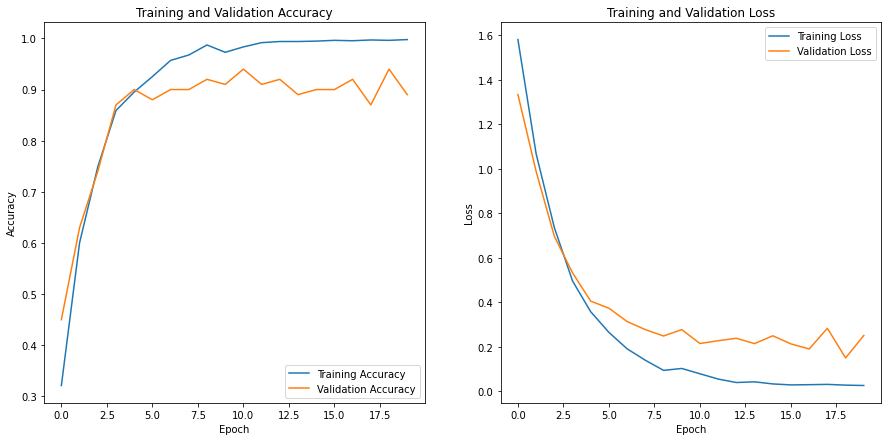

In [ ]:
plot(history_model10)


**Observation**
1. Training Accuracy: 99.6
2. Validation Accuracy: 94
3. Train Loss: 0.027
4. Val Loss: 0.14
5. Best Model with highest training and validation accuracy.